In [23]:
#Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import torch.nn.functional as F
import time

In [24]:
#Getting the data
path = '../data-unversioned'
cf10 = datasets.CIFAR10(path, train= True, download= True)
cf10_val = datasets.CIFAR10(path, train= False, download= True)

Files already downloaded and verified
Files already downloaded and verified


In [25]:
#GPU Checking

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


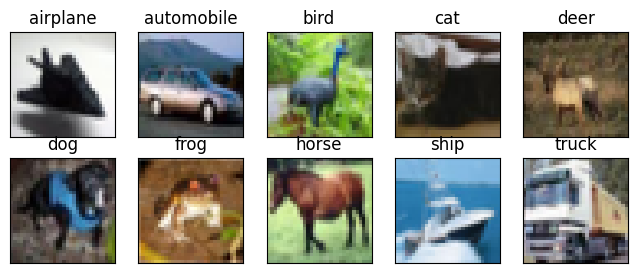

In [26]:
#Display Classes
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
fig1 = plt.figure(figsize=(8,3))
class_size = 10
for i in range(class_size):
    plt1 = fig1.add_subplot(2, 5, 1 + i, xticks= [], yticks= [])
    plt1.set_title(classes[i])
    image = next(image for image, label in cf10 if label == i)
    plt.imshow(image)
plt.show()

In [27]:
#Grabbing Datasets as a tensor
cf10_ten = datasets.CIFAR10(path, train= True, download= False, transform= transforms.ToTensor())
imTen, _ = cf10_ten[99]
#imTen.shape, imTen.dtype

#Image Stacking
Stacked_images = torch.stack([imTen for imTen, _ in cf10_ten], dim= 3)
Stacked_images = torch.flatten(Stacked_images)
Stacked_images.shape

torch.Size([153600000])

In [28]:
#Re-Grabbing data to normalize
transCF10 = datasets.CIFAR10(path, train= True, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]))
transCF10_val = datasets.CIFAR10(path, train= False, download= False, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4915, 0.4823, 0.4468),(0.2470, 0.2435, 0.2616))]))

In [29]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []
val_accuracy_list = []
all_predicted = []
all_labels = []

def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for Stacked_images, labels in training_loader:
      Stacked_images = Stacked_images.to(device)
      labels = labels.to(device)
      outputs = model(Stacked_images)
      loss = loss_fn(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    train_loss_list.append(loss_train / len(training_loader)) 

    
    #Validation Loop
    correct = 0
    total = 0
    valid_loss = 0.0
    model.eval()
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          all_predicted.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

    val_loss_list.append(valid_loss / len(valid_loader))
    val_accuracy = correct / total
    val_accuracy_list.append(val_accuracy)

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader)))


In [30]:
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channels, out_channels, stride= 1):
    super(BasicBlock, self).__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channels != self.expansion*out_channels:
      self.shortcut = nn.Sequential(
        nn.Conv2d(in_channels, self.expansion*out_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(self.expansion*out_channels)
      )


  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out

In [31]:
class ResNet11(nn.Module):
  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet11, self).__init__()
    self.in_channels = 64

    # Initial convolutional layer
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)

    # Second initial convolutional layer
    self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(64)

    # Residual blocks
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

    # Global Average Pooling
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

    # Dropout
    self.dropout = nn.Dropout(0.5)

    # Fully connected layer
    self.fc = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.avg_pool(out)
    out = out.view(out.size(0), -1)
    out = self.dropout(out)
    out = self.fc(out)
    return out

In [32]:
model = ResNet11(BasicBlock, [1, 1, 1, 1], num_classes= 10).to(device) # 2 initial, 8 residual (2 + 2 + 2 + 2), 1 final
a = 0.01
epochs = 20
lossFN = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr= a)
training_loader = torch.utils.data.DataLoader(transCF10, batch_size= 64, shuffle= True)
valid_loader = torch.utils.data.DataLoader(transCF10_val, batch_size= 64, shuffle= True)
start_time = time.time()

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader
)

#Getting the time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time/60} Minutes")

Epoch: 1, Training Loss: 1.5513307710590265, Validation Loss: 1.539213153966673
Epoch: 5, Training Loss: 0.7020750220321939, Validation Loss: 0.9563996588728231
Epoch: 10, Training Loss: 0.2738685940994936, Validation Loss: 1.570614001933177
Epoch: 15, Training Loss: 0.0708849664879939, Validation Loss: 1.2721387387081315
Epoch: 20, Training Loss: 0.020006860928821955, Validation Loss: 1.0026709154532973
Time taken: 7.205858325958252 Minutes


In [33]:
# Calculate and print the accuracy
accuracy = val_accuracy_list[-1]
print(f'Accuracy: {accuracy:.4f}')

# Calculate and print precision, recall, and F1 score
precision = precision_score(all_labels, all_predicted, average='macro')
recall = recall_score(all_labels, all_predicted, average='macro')
f1 = f1_score(all_labels, all_predicted, average='macro')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Save the model weights
#torch.save(model.state_dict(), './model/DLHW1P1B.pth')  # .pth is the recommended extension

#Complexity
numel_list = [p.numel() for p in model.parameters()]
print("Model Complexity: {}".format(sum(numel_list)))
#sum(numel_list), numel_list

Accuracy: 0.7682
Precision: 0.6542
Recall: 0.6461
F1 Score: 0.6482
Model Complexity: 4940234


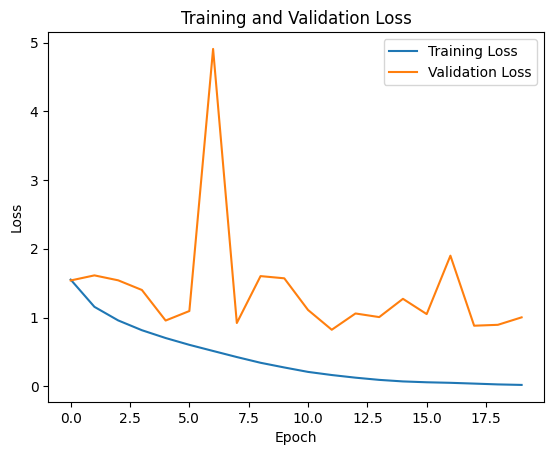

In [34]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
#plt.savefig('temp/LeNet_training_validation_loss.png')
plt.show()